## Upload excel file for training and validation

In [14]:
from google.colab import files
uploaded = files.upload()
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
         name=fn, length=len(uploaded[fn])))

Saving data01.xlsx to data01 (33).xlsx
User uploaded file "data01.xlsx" with length 9982 bytes


In [15]:
import os
import math
import numpy as np
import pandas as pd

!pip install xlrd

import tensorflow as tf
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# This are just to get reproducible results
# from these libraries.
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(17)
tf.set_random_seed(17)
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, 
                              inter_op_parallelism_threads=1)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

In [16]:
df_xl   = pd.read_excel(fn)
df      = df_xl.transpose()
# df      = df.loc[:,:1]
# counter   = np.asarray([i for i in range(40)])
# test_mat  = np.asarray([counter, 2*counter]).transpose()
# df = pd.DataFrame(test_mat, columns=['a', 'b'])
display(df[:5])

# data preset variables 
train_size       = 35
test_size        = 5
n_outs           = df.shape[1]

# Neural Network variables
batch_size       = 1
look_back        = 2
n_hidden_neurons = 4
nn_model         = "nn_model.h5"; # HDF5 file

,0,1,2,3,4,5,6
Input 1,1,5,10,14,23,24,38
Input 2,2,4,9,24,25,27,45
Input 3,3,1,5,11,32,40,45
Input 4,4,19,36,39,41,46,51
Input 5,5,10,11,19,41,50,54


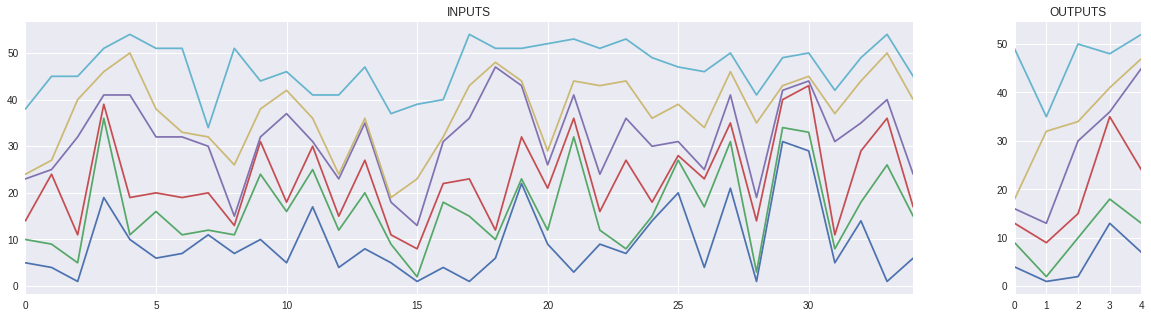

In [17]:
# find patterns in the data
import matplotlib.pyplot as plt
from matplotlib import gridspec


inputs = df.as_matrix()[0:train_size]
outputs = df.as_matrix()[train_size:]

plt.figure(figsize=(20,5))
gs = gridspec.GridSpec(1, 2, width_ratios=[7, 1]) 


plt.subplot(gs[0])
for i in range(1,inputs.shape[1]):
  plt.plot(inputs[:,i])
plt.title('INPUTS')
plt.xlim(0,train_size-1)

plt.subplot(gs[1])
for i in range(1,outputs.shape[1]):
  plt.plot(outputs[:,i])
plt.title('OUTPUTS')
plt.xlim(0,test_size-1)

plt.show()

In [18]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), :]
		dataX.append(a)
		dataY.append(dataset[i + look_back, :])
	return np.array(dataX), np.array(dataY)


# normalize dataset
dataset = df.values
dataset = dataset.astype('float32')
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

print("Dataset  shape=", dataset.shape)
#print(dataset[0:5,:])

# split into train and test sets
n_features = dataset.shape[1]

train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

print("train, test :", train.shape, test.shape)

# reshape into X=t and Y=t+1

trainX, trainY = create_dataset(train, look_back)
testX, testY   = create_dataset(test, look_back)

print("Train X, Y ", trainX.shape, trainY.shape)
print("Test  X, Y ", testX.shape, testY.shape)

# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], n_features))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], n_features))

print("reshaped Train X, Y ", trainX.shape, trainY.shape)

#
# create and fit the LSTM network
# The input_shape defines the shape of input layer, 
# The LSTM is the first hidden layer, 
# The Dense is the output layer.
#
model = Sequential()
model.add(LSTM(n_hidden_neurons, 
               batch_input_shape=(batch_size, look_back, n_features), 
               stateful=True))
model.add(Dense(n_outs))

print(model.summary())

Dataset  shape= (40, 7)
train, test : (35, 7) (5, 7)
Train X, Y  (32, 2, 7) (32, 7)
Test  X, Y  (2, 2, 7) (2, 7)
reshaped Train X, Y  (32, 2, 7) (32, 7)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (1, 4)                    192       
_________________________________________________________________
dense_2 (Dense)              (1, 7)                    35        
Total params: 227
Trainable params: 227
Non-trainable params: 0
_________________________________________________________________
None


In [0]:
model.compile(loss='mean_squared_error', optimizer='adam')
for i in range(200):
	model.fit(trainX, trainY, epochs=1, batch_size=batch_size, 
            verbose=0, shuffle=False)
	model.reset_states()
# make predictions
trainPredict = model.predict(trainX, batch_size=batch_size)
model.reset_states()
testPredict = model.predict(testX, batch_size=batch_size)

# save the model
model.save(nn_model, overwrite=True)
#files.download(nn_model)

In [20]:
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform(trainY)
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform(testY)

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY, trainPredict))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY, testPredict))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 6.85 RMSE
Test Score: 5.89 RMSE


[[36.        4.        9.       13.       16.       18.       49.      ]
 [37.        1.        2.        9.       13.       32.       35.      ]
 [38.        2.       10.       15.       30.       34.       50.      ]
 [39.       13.       18.       35.       36.       41.       48.      ]
 [40.        7.       13.       24.       45.       47.       52.000004]]
[[28.801786 10.176972 18.510298 25.43817  27.996395 37.92903  47.49893 ]
 [36.17169  16.364105 25.652569 31.903492 33.270233 44.960415 52.10011 ]]


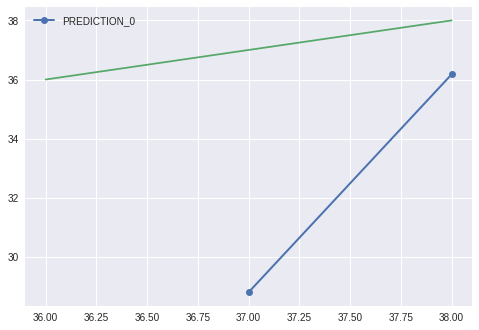

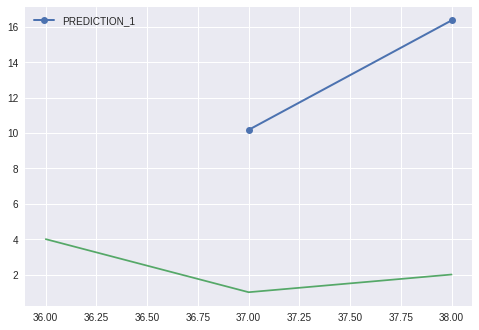

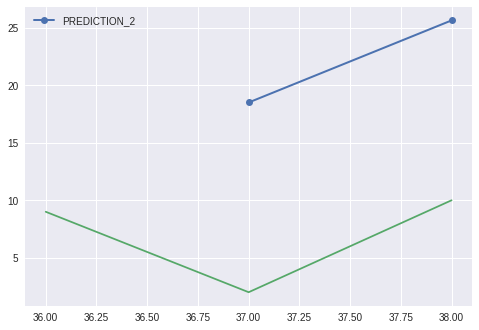

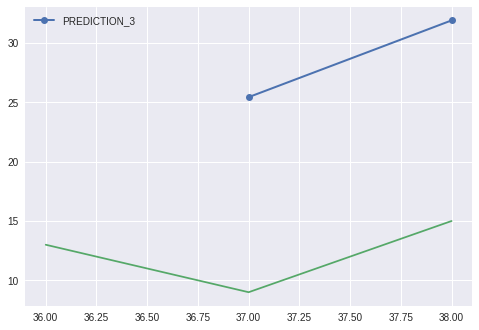

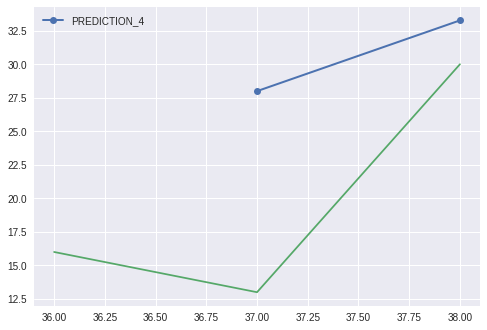

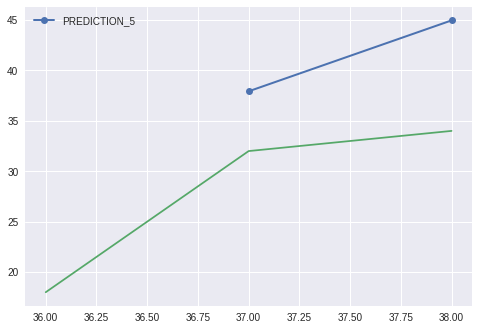

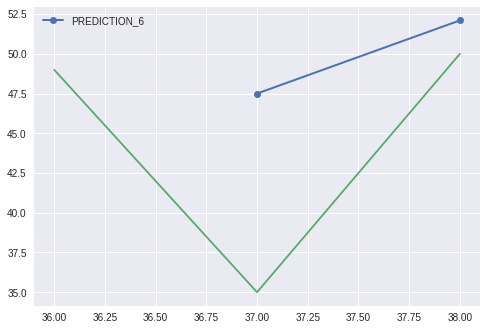

In [21]:
test_p =  scaler.inverse_transform(test[0:test_size-look_back])
print (scaler.inverse_transform(test))
print (testPredict)

# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, 
                 :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1,
                :] = testPredict
# shift test data
testPlot = np.empty_like(dataset)
testPlot[:, :] = np.nan
testPlot[train_size+1:train_size+test_size-look_back+1, :] = test_p

#plt.figure(figsize=(5,n_features*5))
for pi in range(n_features):
  #plt.subplot(1, n_features, pi+1)
  plt.plot(testPredictPlot[:,pi], label='PREDICTION_'+str(pi), marker='o', 
           linewidth=2.0)
  plt.plot(testPlot[:,pi])
  
  plt.legend()
  plt.show()